## Практическая работа к занятию №4

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten,
                                     Conv2D, MaxPooling2D, AveragePooling2D,
                                     Input, Concatenate)
from tensorflow.keras.utils import plot_model

In [3]:
!nvidia-smi

Wed Feb 16 13:49:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Подготовка данных

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170508288/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


Генератор с аугментациями

In [5]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10)

### Архитектуры

Всего будет 4 архитектуры.

В каждой из них также будет вариант изменить количество фильтров. При обучении будет рассмотрен вариант 16 и 32

Начальная архитектура с 2 свертками параллельно. В конце 2 полносвязных слоя

In [9]:
def get_model_1(filters):
    first_input = Input(shape=(32, 32, 3))

    x11= Conv2D(filters, 3, activation='relu', padding='same')(first_input)
    x12= Conv2D(filters, 5, activation='relu', padding='same')(first_input)

    merge_1 = Concatenate()([x11, x12])
    flatten = Flatten()(merge_1)
    dense_1 = Dense(64, activation='tanh')(flatten)
    out = Dense(num_classes, activation='softmax')(dense_1)

    model = Model(inputs=first_input, outputs=out)

    return model

Добавим avg пулинги после каждой свертки. Далее все модели только с пулингами

In [10]:
def get_model_2(filters):
    first_input = Input(shape=(32, 32, 3))

    x11 = Conv2D(filters, 3, activation='relu', padding='same')(first_input)
    x11_pool = AveragePooling2D()(x11)
    x12 = Conv2D(filters, 5, activation='relu', padding='same')(first_input)
    x12_pool = AveragePooling2D()(x12)

    merge_1 = Concatenate()([x11_pool, x12_pool])
    flatten = Flatten()(merge_1)
    dense_1 = Dense(64, activation='tanh')(flatten)
    out = Dense(num_classes, activation='softmax')(dense_1)

    model = Model(inputs=first_input, outputs=out)

    return model

Увеличим ширину сети, добавив еще одну свертку параллельно

In [11]:
def get_model_3(filters):
    first_input = Input(shape=(32, 32, 3))

    x11 = Conv2D(filters, 3, activation='relu', padding='same')(first_input)
    x12 = Conv2D(filters, 5, activation='relu', padding='same')(first_input)
    x13 = Conv2D(filters, 7, activation='relu', padding='same')(first_input)

    merge_1 = Concatenate()([x11, x12, x13])
    flatten = Flatten()(merge_1)
    dense_1 = Dense(64, activation='tanh')(flatten)
    out = Dense(num_classes, activation='softmax')(dense_1)

    model = Model(inputs=first_input, outputs=out)

    return model

Увеличим глубину сети, отталкиваясь от 2 варианта. То есть добавим еще один блок с 2 параллельными свертками<br>
Но паддинг делать не будем. в 1 случае две свертки подряд ядром 3. во 2 случае 1 свертка ядром 5. Для совпадения размерностей

In [13]:
def get_model_4(filters):
    first_input = Input(shape=(32, 32, 3))

    x1_1 = Conv2D(filters, 3, activation='relu', padding='same')(first_input)
    x1_2 = Conv2D(filters, 5, activation='relu', padding='same')(first_input)

    merge_1 = Concatenate()([x1_1, x1_2])

    x2_1 = Conv2D(filters, 3, activation='relu')(merge_1)
    x2_1_2 = Conv2D(filters, 3, activation='relu')(x2_1)
    x2_2 = Conv2D(filters, 5, activation='relu')(merge_1)

    merge_2 = Concatenate()([x2_1_2, x2_2])

    flatten = Flatten()(merge_2)
    dense_1 = Dense(64, activation='tanh')(flatten)
    out = Dense(num_classes, activation='softmax')(dense_1)

    model = Model(inputs=first_input, outputs=out)

    return model

Посмотрим на получившиеся архитектуры для вариант с 16 фильтрами в каждой свертке

In [14]:
models = {
    'model_1_16f': get_model_1(filters=16),
    'model_2_16f': get_model_2(filters=16),
    'model_3_16f': get_model_3(filters=16),
    'model_4_16f': get_model_4(filters=16),
    'model_1_32f': get_model_1(filters=32),
    'model_2_32f': get_model_2(filters=32),
    'model_3_32f': get_model_3(filters=32),
    'model_4_32f': get_model_4(filters=32)
}

def get_model(name):
    model = models[name]
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

################################### model_1_16f ###################################


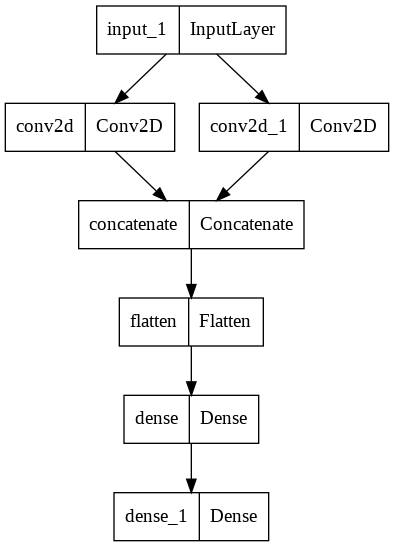

################################### model_2_16f ###################################


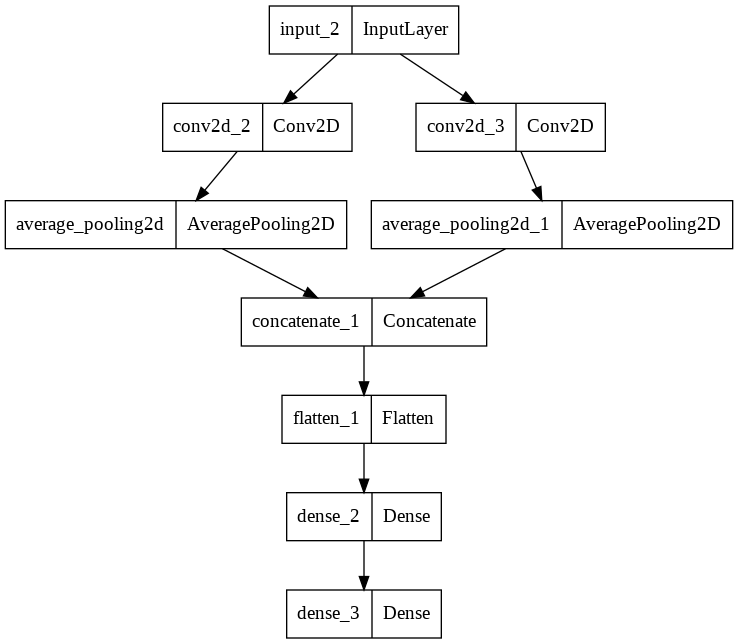

################################### model_3_16f ###################################


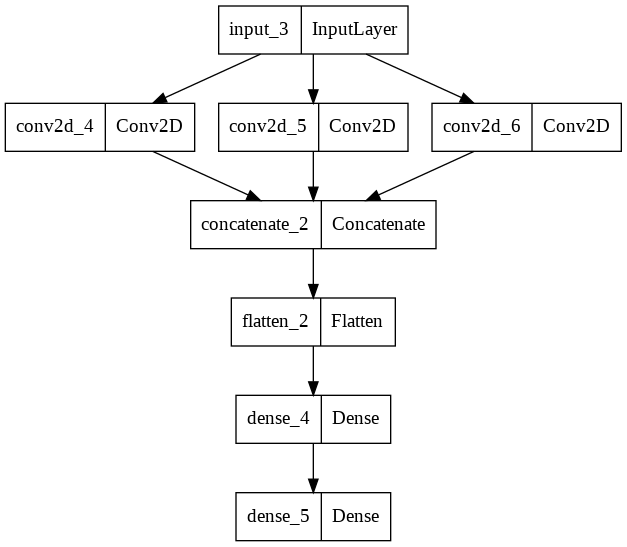

################################### model_4_16f ###################################


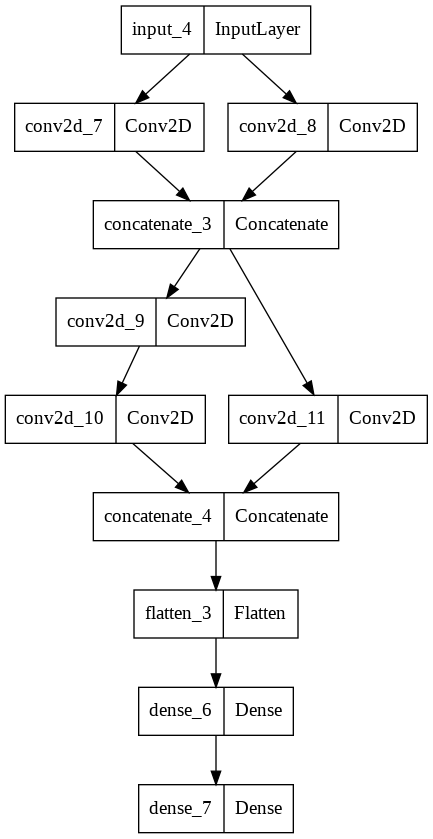

In [15]:
for model_name in list(models.keys())[:4]:
    print('#' * 35, model_name, '#' * 35)
    display(plot_model(get_model(model_name), f'{model_name}.png'))

### Обучение моделей

In [16]:
results = {}
    
def train_model(name, batch_size=1024, epochs=15):
    print(f"Processing {name}...")
    model = get_model(name)
    train_history = model.fit(
                            #   x_train, y_train,
                              datagen.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=0)
    train_logs = model.evaluate(x_train, y_train, verbose=0)
    test_logs = model.evaluate(x_test, y_test, verbose=0)

    return {
        'train_history': train_history.history,
        'train_acc': train_logs[1],
        'test_acc': test_logs[1]
    }

In [17]:
for model_name in models.keys():
    results[model_name] = train_model(model_name)

Processing model_1_16f...
Processing model_2_16f...
Processing model_3_16f...
Processing model_4_16f...
Processing model_1_32f...
Processing model_2_32f...
Processing model_3_32f...
Processing model_4_32f...


In [18]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['train_acc', 'test_acc'])
df_results.sort_values(by='test_acc', ascending=False, inplace=True)
df_results

,train_acc,test_acc
model_4_32f,0.77860,0.6990
model_3_32f,0.74456,0.6618
model_4_16f,0.71052,0.6534
model_1_32f,0.71912,0.6519
model_3_16f,0.71294,0.6468
model_2_32f,0.67960,0.6448
model_1_16f,0.70174,0.6348
model_2_16f,0.65808,0.6318


Выводы:
1. Увеличение глубины значительно улучшило качество модели. 1 и 3 место при количестве фильтров 32 и 16 в сверточных слоях
2. Увеличение ширины сети также привело к улучшению качества классификации
3. Увеличение количества фильтров в сверточных слоях во всех моделях привело к улучшению качества
4. Average pooling в данной задаче не улучшает модель. Скорей всего потому что картинки и так маленького размера. Нет необходимости стремиться уменьшить количество обучаемых параметров